In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [12]:
import sys
sys.path.insert(1, 'Modules/')
from Evaluation_Metric import Metric_regression
from Cross_validation import preparation_cross_validation
golden_section_search = __import__('20220716_Golden_Section_Search').golden_section_search
from Primal_Pegasos import Pegasos_regression
Pegasos_kernel = __import__('Kernel_Pegasos').Pegasos_kernel_regression
Kernel = __import__('Kernel_Pegasos').Kernel_polynomial   

In [4]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [5]:
X_nan = np.isnan(data)
X_nan = X_nan.sum(axis=1)
X_no_nan = X_nan == 0
X = data[X_no_nan,:]
y = target[X_no_nan]

In [6]:
X = X - X.mean(axis=0)
X = X / X.var(axis=0)**0.5

In [7]:
np.random.seed(42)
n = X.shape[0]
split_fraction = 0.8
n_random = np.random.permutation(n)
n_train = n_random[:int(n*split_fraction)]
n_test = n_random[int(n*split_fraction):]

X_train = X[n_train,:]
y_train = y[n_train]

X_test = X[n_test,:]
y_test =  y[n_test]

In [9]:
n_bags = 3
np.random.seed(42)
bags_list = preparation_cross_validation(X_train, y_train, n_bags)

In [13]:
l_opt_list = []
epoch_max_diagram = 100
def MSE_l (l, Pegasos_regression, epoch_max, epsilon, X_train, y_train, X_val, y_val):
    Pegasos = Pegasos_regression(regularization=l,
                                 epoch_max=epoch_max,
                                 epsilon=epsilon,
                                 verbose=False)
    Pegasos.fit(X_train, y_train)
    MSE_ = Pegasos.MSE(X_val, y_val)
    return (MSE_) 

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [11:31<00:00, 230.38s/it]


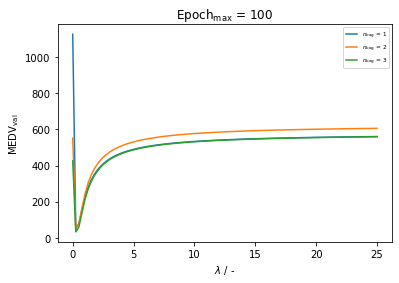

In [15]:
legend_list = ['$n\mathrm{_{bag}}$ = ' + str(i+1) for i in range(n_bags)]
l_array = np.linspace(0.00001, 25, 100)
for n_val in tqdm(range (n_bags)):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)

    MSE_min = lambda l: MSE_l(l, 
                              Pegasos_regression=Pegasos_regression, 
                              epoch_max=epoch_max_diagram, 
                              epsilon=1E-8, 
                              X_train=X_train_, 
                              y_train=y_train_, 
                              X_val=X_val_, 
                              y_val=y_val_)
    MSE_min_vec = np.vectorize(MSE_min)
    plt.plot(l_array, MSE_min_vec(l_array))

plt.title('Epoch$\mathrm{_{max}}$ = ' + '{:.0f}'.format(epoch_max_diagram))
plt.xlabel('$\lambda$ / -')
plt.ylabel('MEDV$\mathrm{_{val}}$')
plt.legend(legend_list, loc='upper right', fontsize='xx-small')
plt.show()

In [18]:
epoch_max = 100
MSE_mean = 0
MSE_list = []
l_opt_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)

    MSE_min = lambda l: MSE_l(l, 
                              Pegasos_regression=Pegasos_regression,
                              epoch_max=epoch_max, 
                              epsilon=1E-8, 
                              X_train=X_train_, y_train=y_train_, 
                              X_val=X_val_, y_val=y_val_)
    l_opt = golden_section_search(MSE_min, 1E-3, 10, 1E-3)
    l_opt_list.append(l_opt)
    MSE_list.append(MSE_min(l_opt))
    MSE_mean += MSE_min(l_opt) / n_bags 
    print('MSE (on validation set {}/{}) = {:.2g} | lambda = {:.2g}'.format(n_val+1, n_bags, MSE_min(l_opt), l_opt))
MSE_array = np.array(MSE_list)
best_l_array = np.array(l_opt_list)
print('Mean MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, MSE_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))

l_best_linear = best_l_array.mean()
Pegasos_linear_CV = Pegasos_regression(regularization=l_best_linear,
                             epoch_max=epoch_max,
                             epsilon=1E-8)
Pegasos_linear_CV.fit(X_train, y_train)

MSE (on validation set 1/3) = 33 | lambda = 0.0073
MSE (on validation set 2/3) = 31 | lambda = 0.0045


 11%|████████▊                                                                       | 11/100 [00:00<00:00, 102.80it/s]

MSE (on validation set 3/3) = 21 | lambda = 0.045
Mean MSE Cross Validation = 28 +- 6.5
Best lambda = 0.0189 +- 0.0225
##########
Regularizaion: 0.01892801419394408
Max epoch: 100
Primal Pegasos Linear


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.87it/s]

##########


In [20]:
def MSE_kernel (l, Pegasos, Kernel, epoch_max, epsilon, X_train, y_train, X_val, y_val):
    Pegasos_ = Pegasos(kernel=Kernel,
                              regularization=l,
                              epoch_max=epoch_max,
                              epsilon=epsilon,
                              verbose=False)
    Pegasos_.fit(X_train, y_train)
    MSE_ = Pegasos_.MSE(X_val, y_val)
    return (MSE_) 

In [21]:
MSE_mean = 0
MSE_list = []
Kernel_linear = Kernel(c=0, p=1)
l_opt_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)

    MSE_kernel_lambda = lambda l: MSE_kernel(l,
                                             Pegasos=Pegasos_kernel, 
                                             Kernel=Kernel_linear,  
                                             epoch_max=epoch_max, 
                                             epsilon=1E-8, 
                                             X_train=X_train_, 
                                             y_train=y_train_, 
                                             X_val=X_val_, 
                                             y_val=y_val_)
    
    l_opt = golden_section_search(MSE_kernel_lambda, 1E-5, 100, 1E-3)
    l_opt_list.append(l_opt)
    MSE_list.append(MSE_min(l_opt))
    MSE_mean += MSE_min(l_opt) / n_bags 
    print('MSE (on validation set {}/{}) = {:.2f} | lambda = {:.2g}'.format(n_val+1, n_bags, MSE_min(l_opt), l_opt))
MSE_array = np.array(MSE_list)
best_l_array = np.array(l_opt_list)
print('Mean MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, MSE_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))

l_best = best_l_array.mean()
Pegasos_kernel_linear_CV = Pegasos_kernel(kernel=Kernel_linear,
                                          regularization=l_best,
                                          epoch_max=epoch_max,
                                          epsilon=1E-8,
                                           )
Pegasos_kernel_linear_CV.fit(X_train, y_train)

MSE (on validation set 1/3) = 32.98 | lambda = 0.02
MSE (on validation set 2/3) = 30.28 | lambda = 0.004


  9%|███████▍                                                                          | 9/100 [00:00<00:01, 89.99it/s]

MSE (on validation set 3/3) = 20.66 | lambda = 0.041
Mean MSE Cross Validation = 28 +- 6.5
Best lambda = 0.0219 +- 0.0187
##########
Regularizaion: 0.021884903668500544
Max epoch: 100
Kernel Pegasos: Polynomial kernel (c=0, p=1)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.64it/s]

##########


In [22]:
MSE_mean = 0
MSE_list = []
c_best_list = []
l_best_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)


    best_val = 1E8
    best_l = 0
    best_c = 0
    for c in [0, 1, 5, 10, 50, 100]:
        Kernel_2 = Kernel(c=c, p=2)
        for l in [1E-5, 1E-4, 1E-3, 1E-2, 0.5, 0.1, 0.5, 1, 10]:
            Pegasos_reg_kernel_2 = Pegasos_kernel(kernel=Kernel_2, 
                                                regularization=l, 
                                                epoch_max=epoch_max, 
                                                epsilon=1E-8,
                                                verbose=False)
            Pegasos_reg_kernel_2.fit(X_train_, y_train_)
            MSE_Pegasos_train_2 = Pegasos_reg_kernel_2.MSE(X_train, y_train)
            MSE_Pegasos_val_2 = Pegasos_reg_kernel_2.MSE(X_val_, y_val_)
            #print('Train:', MSE_Pegasos_train_2)
            #print('Val:', MSE_Pegasos_val_2)
            if MSE_Pegasos_val_2 < best_val:
                best_l = l
                best_val = MSE_Pegasos_val_2        
                best_c = c
    c_best_list.append(best_c)
    l_best_list.append(best_l)
    MSE_list.append(MSE_min(l_opt))

    MSE_mean += best_val / n_bags 
    print('MSE (on validation set {}/{}) = {:.2f} | c = {} | lambda = {:.2g}'.format(n_val+1, n_bags, best_val, best_c, best_l))
MSE_array = np.array(MSE_list)
best_l_array = np.array(l_best_list)
c_best_array = np.array(c_best_list)
print('Mean MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, MSE_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))
print('Best c = {:.3g} +- {:.3g}'.format(c_best_array.mean(), c_best_array.var(ddof=1)**0.5))

l_best = best_l_array.mean()
c_best = c_best_array.mean()
Kernel_2 = Kernel(c=c_best, p=2)
Pegasos_kernel_quadratic_CV = Pegasos_kernel(kernel=Kernel_2,
                                          regularization=l_best,
                                          epoch_max=epoch_max,
                                          epsilon=1E-8,
                                           )
Pegasos_kernel_quadratic_CV.fit(X_train, y_train)

MSE (on validation set 1/3) = 19.90 | c = 100 | lambda = 0.5
MSE (on validation set 2/3) = 12.87 | c = 10 | lambda = 0.01


  8%|██████▌                                                                           | 8/100 [00:00<00:01, 79.20it/s]

MSE (on validation set 3/3) = 7.17 | c = 50 | lambda = 0.5
Mean MSE Cross Validation = 13 +- 7.9
Best lambda = 0.337 +- 0.283
Best c = 53.3 +- 45.1
##########
Regularizaion: 0.33666666666666667
Max epoch: 100
Kernel Pegasos: Polynomial kernel (c=53.333333333333336, p=2)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.83it/s]

##########


In [24]:
MSE_mean = 0
MSE_list = []
c_best_list = []
l_best_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)


    best_val = 1E8
    best_l = 0
    best_c = 0
    for c in [0, 1, 5, 10, 50, 100]:
        Kernel_3 = Kernel(c=c, p=3)
        for l in [1, 5, 10, 50, 100, 1000]:
            Pegasos_reg_kernel_3 = Pegasos_kernel(kernel=Kernel_3, 
                                                regularization=l, 
                                                epoch_max=epoch_max, 
                                                epsilon=1E-8,
                                                verbose=False)
            Pegasos_reg_kernel_3.fit(X_train_, y_train_)
            MSE_Pegasos_train_3 = Pegasos_reg_kernel_3.MSE(X_train, y_train)
            MSE_Pegasos_val_3 = Pegasos_reg_kernel_3.MSE(X_val_, y_val_)
            #print('Train:', MSE_Pegasos_train_2)
            #print('Val:', MSE_Pegasos_val_2)
            if MSE_Pegasos_val_3 < best_val:
                best_l = l
                best_val = MSE_Pegasos_val_3        
                best_c = c
    c_best_list.append(best_c)
    l_best_list.append(best_l)
    MSE_list.append(MSE_min(l_opt))

    MSE_mean += best_val / n_bags 
    print('MSE (on validation set {}/{}) = {:.2f} | c = {} | lambda = {:.2g}'.format(n_val+1, n_bags, best_val, best_c, best_l))
best_l_array = np.array(l_best_list)
c_best_array = np.array(c_best_list)
print('Mean MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, best_l_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))

l_best = best_l_array.mean()
c_best = c_best_array.mean()
Kernel_3 = Kernel(c=c_best, p=3)
Pegasos_kernel_kubic_CV = Pegasos_kernel(kernel=Kernel_3,
                                          regularization=l_best,
                                          epoch_max=epoch_max,
                                          epsilon=1E-8,
                                           )
Pegasos_kernel_kubic_CV.fit(X_train, y_train)

MSE (on validation set 1/3) = 19.48 | c = 100 | lambda = 50
MSE (on validation set 2/3) = 11.58 | c = 50 | lambda = 5


  6%|████▉                                                                             | 6/100 [00:00<00:01, 54.05it/s]

MSE (on validation set 3/3) = 6.92 | c = 50 | lambda = 50
Mean MSE Cross Validation = 13 +- 26
Best lambda = 35 +- 26
##########
Regularizaion: 35.0
Max epoch: 100
Kernel Pegasos: Polynomial kernel (c=66.66666666666667, p=3)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.75it/s]

##########


In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_sklearn = np.dot(X_test, lin_reg.coef_) + lin_reg.intercept_

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
compare_weights = pd.DataFrame()
compare_weights['Name'] = ['Bias'] + list(column_names[:-1])
compare_weights['Linear Regression'] = np.append(lin_reg.intercept_, lin_reg.coef_)
compare_weights['Pegasos linear'] = np.append(Pegasos_linear_CV.theta_0, Pegasos_linear_CV.theta)
pd.set_option('display.precision', 3)
print(compare_weights.T)  

                      0      1      2      3     4      5     6      7     8  \
Name               Bias   CRIM     ZN  INDUS  CHAS    NOX    RM    AGE   DIS   
Linear Regression  22.6 -0.892   1.22 -0.136  0.59     -2  2.53  0.296 -3.23   
Pegasos linear     21.6 -0.675  0.712 -0.165  0.46 -0.809   3.3 -0.496 -1.57   

                       9    10       11     12     13  
Name                 RAD   TAX  PTRATIO      B  LSTAT  
Linear Regression   2.85 -2.44    -1.97  0.791  -3.91  
Pegasos linear     0.932 -1.24    -1.66  0.992  -2.23  


In [31]:
MSE_compare = pd.Series(dtype=float)
ARD_compare = pd.Series(dtype=float) 
MSE_compare['Sklearn'] = Metric_regression().fun_MSE(y_test, y_test_sklearn)
MSE_compare['Pegasos (linear)'] = Pegasos_linear_CV.MSE(X_test, y_test)
MSE_compare['Pegasos (Kernel - linear)'] = Pegasos_kernel_linear_CV.MSE(X_test, y_test)
MSE_compare['Pegasos (Kernel - quadratic)'] = Pegasos_kernel_quadratic_CV.MSE(X_test, y_test)
MSE_compare['Pegasos (Kernel - kubic)'] = Pegasos_kernel_kubic_CV.MSE(X_test, y_test)

ARD_compare['Sklearn'] = 0
ARD_compare['Pegasos (linear)'] = -(MSE_compare['Pegasos (linear)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100
ARD_compare['Pegasos (Kernel - linear)'] = -(MSE_compare['Pegasos (Kernel - linear)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100
ARD_compare['Pegasos (Kernel - quadratic)'] = -(MSE_compare['Pegasos (Kernel - quadratic)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100
ARD_compare['Pegasos (Kernel - kubic)'] = -(MSE_compare['Pegasos (Kernel - kubic)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100

MSE_DF = MSE_compare.to_frame(name='MSE')
ARD_DF = ARD_compare.to_frame(name='Deviation / %')
performance_DF = pd.concat([ARD_DF, MSE_DF], axis=1)
print(performance_DF)

                              Deviation / %     MSE
Sklearn                               0.000  22.266
Pegasos (linear)                     -3.729  23.097
Pegasos (Kernel - linear)            -4.075  23.174
Pegasos (Kernel - quadratic)         34.558  14.571
Pegasos (Kernel - kubic)             38.683  13.653


In [ ]:
MSE_train = []
MSE_val = []
train_samples = []
Pegasos_linear_CV = Pegasos_regression(regularization=l_best_linear,
                             epoch_max=epoch_max,
                             epsilon=1E-8,
                             verbose=False)

n = X_train.shape[0]
split_fraction = 0.8
n_split = int(n * split_fraction)
X_val_ = X_train[n_split:,:]
y_val_ = y_train[n_split:]

lin_reg_sub = LinearRegression()
lin_reg_sub.fit(X_train[:n_split,:], y_train[:n_split])
y_val = np.dot(X_val_, lin_reg.coef_) + lin_reg.intercept_
MSE_epsilon = Metric_regression().fun_MSE(y_val, y_val_)

n_start = 1
for n_sample in tqdm(range(n_start, n_split)):
    train_samples.append(n_sample)
    X_train_sub = X_train[:n_sample,:]
    y_train_sub = y_train[:n_sample]
    
    Pegasos_linear_CV.fit(X_train_sub, y_train_sub)
    MSE_train.append(Pegasos_linear_CV.MSE(X_train_sub, y_train_sub))
    MSE_val.append(Pegasos_linear_CV.MSE(X_val_, y_val_))
   
plt.plot(train_samples, [MSE_epsilon for n in range(n_start, n_split)])
plt.plot(train_samples, MSE_train)
plt.plot(train_samples, MSE_val)
plt.xlim(0, n_split)
plt.xlabel('$n_\mathrm{{train}}$ / -')
plt.ylabel('MSE')
plt.legend(['$\epsilon$','Training', 'Testing'])
plt.yscale('log')
plt.show()

 68%|██████████████████████████████████████████████████████▍                         | 219/322 [01:06<01:00,  1.71it/s]